In [1]:
# the code to make plots for Figure 3 (wt curves, prob plots, pop. level)

import torch, sys, os, io, pickle, json
from os.path import exists
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torch import nn
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy.special import softmax
from scipy.stats import wilcoxon

from dynamics.process.rnn import fulltrain
from dynamics.process.rnn import parse
from dynamics.vis import wt_vis
from dynamics.analysis import wt_analysis as wta
from dynamics.utils import utils


%load_ext autoreload
%autoreload 2

In [2]:
def retrieve_behdat(fname_behdat, fname):
    """ helper code to lookup the dat in the behavioral data containing training data
    for entire RNN.
    if fname_behda is a list, just search it (for faster lookup)
    if a filename, load the file."""
    
    fname_base = fname.split('/')[-1]
    dat = None
    
    if type(fname_behdat) is list:  #easier to recylce
        datlist = fname_behdat
    else:
        datlist = json.load(open(fname_behdat,'r'))
 
    for j in datlist:
        if j['name'] == fname_base:
            dat = j
            break
            
    return dat

In [13]:
# decide which network result to load
num = 3   # number of RNN. kind_cl = 1:50, nok_cl and nok_nocl = 1:20
s_idx = 0  # type of curriculum: 0 = kindergarten + shapin, 1 = shaping only, 2 = no shaping
tphase = 5  # phase of training. working backwards:6 = block w frozen weights, 5=block, 4=catch, 3=nocatch, 2=inference, 1=hardkind, 0= simplekind
idx = 10  # progress within a given phase of trainign. inference is variable. but max is typically 10 for others
dbase = '/Users/dhocker/projects/dynamics/results/20231003/'

d = utils.getfnames(num, s_idx, tphase, idx, dbase=dbase,
              reg_idx=0, block='mixed', epoch='wait')

loading stats


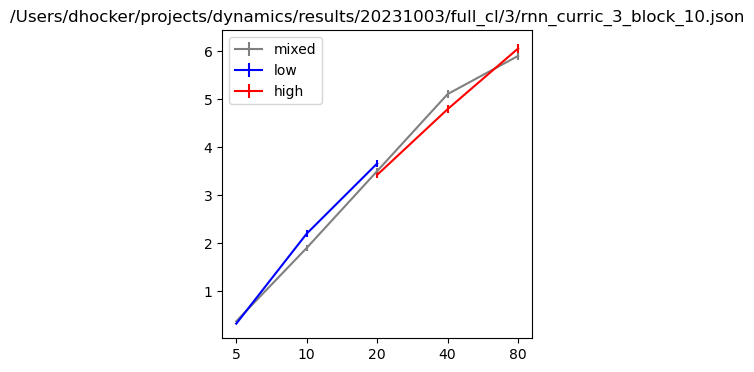

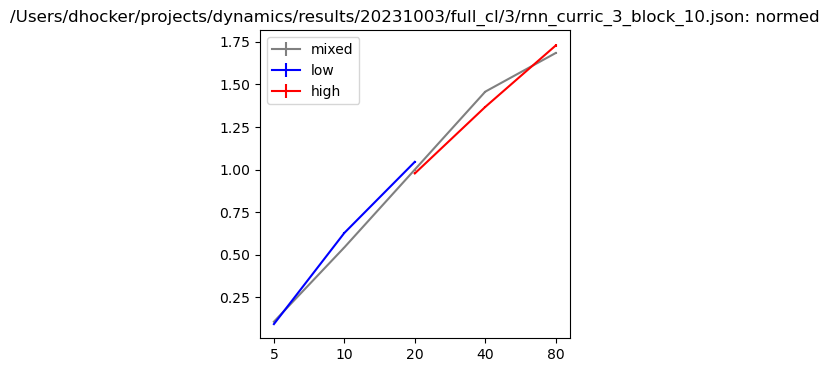

proportion of hits, opt-outs, vios
[0.5073, 0.4937, -0.0010000000000000009]
wait time ratio
0.9350548831972982


In [14]:
print('loading stats')
dat_stat = pickle.load(open(d['stats'],'rb'))
wt_dict = dat_stat[0]
pval,slope,adapt_20_ratio,nums, wtrange,b, wtdat, reg_histdat, reg_blockdat = parse.load_dat4stats(d['stats'])

# wait time curve (Fig. 2 and supp fig 4)
fig, fig2 = wt_vis.plotblocks(wt_dict, name=d['dat'])

print('proportion of hits, opt-outs, vios')
print([nums['win'],nums['optout'], 1-nums['win'] - nums['optout']])
print('wait time ratio')
print(adapt_20_ratio)

In [15]:
#prediction plots

# load full dataset here
print('loading prev. simulated')
with open(d['dat_1k'],'r') as f:
    dat = json.load(f)
    dat = parse.json2dat(dat)

#preprocess
sflat, inp, tdict = parse.get_trialtimes(dat)
warpstate = False
preds = dat['preds']
rew = dat['rewvols']
inp = np.array([np.squeeze(np.squeeze(k[0].detach().numpy())) for k in inp])
offers = inp[inp[:,0]>0,0]

#sometimes there is a fencepost error. maybe a trial not finishing?
nx = min([len(tdict['start']), len(offers)])

preds_ontrial = np.zeros((nx,3))
predflat = []
for k in preds:
    predflat.extend(k)


for k in range(nx):
    idx = tdict['start'][k] # for block prediction
    preds_ontrial[k,:] = softmax(predflat[idx])


#the plot itself
fig = plt.figure(figsize=(10,4))
Vlab = ['p_mixed','p_high','p_low']

block_redo = np.array(dat['blocks'])
block_redo[block_redo==1] = 10
block_redo[block_redo==2] = -10
block_redo[block_redo==10] = 1
block_redo[block_redo==-10] = -1

colors = ['gray','red','blue', 'brown','brown']
for k in range(3):
    #plt.plot(utils.mwa(preds_ontrial[:,k],10),label=Vlab[k], color = colors[k])
    plt.plot(preds_ontrial[:,k],label=Vlab[k], color = colors[k])

plt.xlabel('trial')
plt.ylabel('p')
ax = plt.gca()
ax2=plt.gca().twinx()
ax2.plot(block_redo,'gray')
ax2.set_yticks([0,1,-1],labels=['mixed','high','low'])
plt.title('predictions: RNN ' + d['dat'])
plt.xlim([0,400])
ax.legend()
plt.show()

loading prev. simulated


FileNotFoundError: [Errno 2] No such file or directory: '/Users/dhocker/projects/dynamics/results/20231003/full_cl/3/rnn_curric_3_block_10_1k.json'

In [117]:
#population level: wait time ratio

ops = utils.opsbase()
ops['useblock'] = True

#decide here what you want to look at
ratios_all = []
idxmax = [10,60,40]

for k in range(3):

    #indices of networks with data
    numuse = []
    
    # max number of networks per CL type
    if k == 0:
        nmax = 51
        tphase_use = 5  # used non-freeze network stats. why??
        
    elif k == 1:  # kind + shaping, shaping
        nmax = 51
        tphase_use = 6  # freeze network
    else:  # no shaping
        nmax = 21
        tphase_use = 5
    
    for j in range(1,nmax):
        
        d = utils.getfnames(j, k, tphase_use, idxmax[k], dbase=dbase,
              reg_idx=0, block='mixed', epoch='wait')
    
        if os.path.exists(d['stats']):
                numuse.append(j)
        else:
            print(d['stats'])

    nuse = len(numuse)
    print('number of RNNs per CL type')
    print(nuse)
    ratios = []

    for j in numuse:
        d = utils.getfnames(j, k, tphase_use, idxmax[k], dbase=dbase,
              reg_idx=0, block='mixed', epoch='wait')
        
        _,_,adapt_20_ratio,_, _,_, _, _, _ = parse.load_dat4stats(d['stats'])
        ratios.append(adapt_20_ratio)

            

        
    ratios_all.append(ratios)
    
ratios_good = ratios_all[0]  # full_cl
ratios_bad = ratios_all[1]  #nok_cl
ratios_bad2 = ratios_all[2]  #nok_nocl
ratios_bads = [ratios_bad,ratios_bad2]
ratios_both = [ratios_good, ratios_bad, ratios_bad2]
ratios_flat = [item for sublist in ratios_both for item in sublist]  # all RNNs
ratios_flat_both = [item for sublist in ratios_bads for item in sublist]  # only the bad curricula


/Users/dhocker/projects/dynamics/results/20231003/full_cl/45/rnn_curric_45_block_10.stats
number of RNNs per CL type
49
/Users/dhocker/projects/dynamics/results/20231003/nok_cl/1/rnn_curric_1_block_60_freeze.stats
/Users/dhocker/projects/dynamics/results/20231003/nok_cl/21/rnn_curric_21_block_60_freeze.stats
/Users/dhocker/projects/dynamics/results/20231003/nok_cl/29/rnn_curric_29_block_60_freeze.stats
/Users/dhocker/projects/dynamics/results/20231003/nok_cl/41/rnn_curric_41_block_60_freeze.stats
number of RNNs per CL type
46
/Users/dhocker/projects/dynamics/results/20231003/nok_nocl/2/rnn_curric_2_block_40_1k.stats
/Users/dhocker/projects/dynamics/results/20231003/nok_nocl/6/rnn_curric_6_block_40_1k.stats
number of RNNs per CL type
18


[0.         0.10416667 0.20833333 0.3125     0.41666667 0.52083333
 0.625      0.72916667 0.83333333 0.9375     1.04166667 1.14583333
 1.25       1.35416667 1.45833333 1.5625     1.66666667 1.77083333
 1.875      1.97916667 2.08333333 2.1875     2.29166667 2.39583333
 2.5       ]


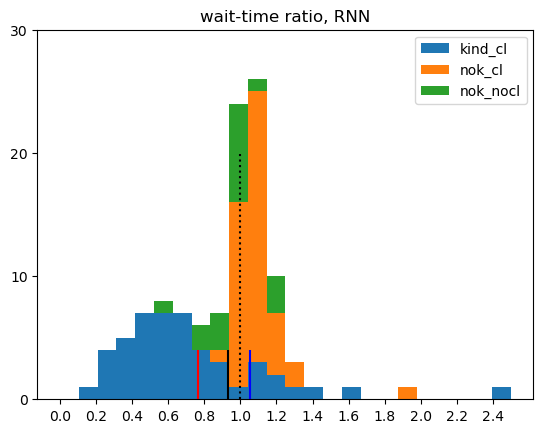

sign rank test: kindergarten CL
WilcoxonResult(statistic=0.0, pvalue=3.552713678800501e-15)
sign rank test: all curriculua
WilcoxonResult(statistic=0.0, pvalue=2.803208638992355e-20)


In [61]:
# adaptation ratio histogram

savedir = '/scratch/dh148/dynamics/results/rnn/ac/20231003/figs/'
fig = plt.figure()
bins = np.linspace(0,2.5,25)
print(bins)

plt.hist([ratios_good, ratios_bad, ratios_bad2], bins, alpha = 1, stacked=True, 
         label = ['kind_cl', 'nok_cl', 'nok_nocl'])
plt.vlines(np.nanmean(ratios_good),0,4,'r') # mean of kind RNNs
plt.vlines(np.nanmean(ratios_flat_both),0,4,'b') # mean of bad RNNs
plt.vlines(np.nanmean(ratios_flat),0,4,'k')  # mean of all RNNS
plt.ylim(0,30)
plt.yticks([0,10,20,30])
plt.xticks([0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4])
plt.vlines(1.0,0,20,'k',linestyle='dotted')

plt.title('wait-time ratio, RNN')
plt.legend()
plt.show()

# calculate the statistic

print('sign rank test: kindergarten CL')
print(wilcoxon(np.array(ratios_good)))
print('sign rank test: all curriculua')
print(wilcoxon(np.array(ratios_flat)))

